# 111th Congress Data

This notebook is meant to call, clean, and examine data from the 2008 election, to produce a viable metric correlating PVI and electoral success.

It feeds into a larger project about fairness in redistricting; for instance, if an R+15 district is unattainable for a Democrat to win, then the district can be wholly classified as "safe," and should be bucketed with R+30 district.

The nuance enters in the margins. How safe is an R+6 district for instance? Can we quantify a district moving from R+3 to R+6 as a significant bias against Democrats? By cleaning this dataset, and others like it, we can determine the predictive power of PVI in each district, and use those probabilities later to assess redistricting fairness.

## Retrieve data from Wikipedia

Wikipedia's current Cook PVI page contains a free and current (up to 2020 election results) version of the index, where free downloads from Cook's website are dated, containing 2018 results and 2016 PVI metrics

In [1]:
import requests
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
#import and format url
url = "https://web.archive.org/web/20100823052807/https://en.wikipedia.org/wiki/Cook_Partisan_Voting_Index"
page = pd.read_html(url)
dat = pd.concat(page,ignore_index=True)

In [3]:
#split data into state and district pvis
    #wiki_district = dat[7:443]
    #wiki_state = dat[448:]
#Scraping is not functional, load in via csv
wiki_district = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/pvi_111.csv")
wiki_state = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/state_111.csv")
#note that DC is accounted for in the district roster
wiki_district = wiki_district[wiki_district.State != "District of Columbia"].reset_index()

In [4]:
#cut NA columns
wiki_district = wiki_district.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
wiki_state = wiki_state.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

In [5]:
#check the various datasets
print(wiki_district.tail(1))
print(wiki_district.head(1))
print(wiki_state.tail(1))
print(wiki_state.head(1))

     index    State  District   PVI Party of\nRepresentative
434    435  Wyoming  At-large  R+20               Republican
   index    State District   PVI Party of\nRepresentative
0      0  Alabama      1st  R+14               Republican
      State   PVI Party\nin Senate
49  Wyoming  R+20       Republican
     State   PVI Party\nin Senate
0  Alabama  R+14       Republican


## Clean and Organize State Data

In [6]:
#call in a dictionary of state abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [7]:
state_111 = wiki_state
state_111["ST"] =  state_111["State"]
#abbreviate the ST coulmn
state_111 = state_111.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(state_111["ST"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [8]:
#split out pvi by party and weight
#first eliminate even values
state_111["PVI"] = state_111["PVI"].str.replace("EVEN","R+0")
state_111["pvi_party"] = state_111.PVI.str[0]
state_111['partisan_weight'] = state_111['PVI'].str.split('+').str[1]
#check results
print(state_111.head(n=1))
print(state_111["pvi_party"].unique())

     State   PVI Party\nin Senate  ST pvi_party partisan_weight
0  Alabama  R+14       Republican  AL         R              14
['R' 'D']


In [9]:
#add constants for later aggregation
state_111["year"] = 2008
state_111["congress"] = 111

In [10]:
#create a variable that is negative when the party is democratic
state_111["neg"] = state_111['pvi_party'].str.replace('D','-')
state_111["neg"] = state_111["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
state_111['partisan_weight'] = state_111["neg"] + state_111['partisan_weight']
#ensure values are integers
state_111['partisan_weight'] = state_111['partisan_weight'].astype(int)

In [11]:
state_111["metric"] = ((state_111['partisan_weight']) + 50) / 100
state_111.head(n=7)

,State,PVI,Party\nin Senate,ST,pvi_party,partisan_weight,year,congress,neg,metric
0,Alabama,R+14,Republican,AL,R,14,2008,111,,0.64
1,Alaska,R+13,Both,AK,R,13,2008,111,,0.63
2,Arizona,R+4,Republican,AZ,R,4,2008,111,,0.54
3,Arkansas,R+9,Democratic,AR,R,9,2008,111,,0.59
4,California,D+8,Democratic,CA,D,-8,2008,111,-,0.42
5,Colorado,R+0,Democratic,CO,R,0,2008,111,,0.50
6,Connecticut,D+7,Democratic,CT,D,-7,2008,111,-,0.43


In [12]:
state_111 = state_111[["year","ST","PVI","metric"]]
state_111.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_111.csv",index=False)

In [13]:
state_111.head(8)

,year,ST,PVI,metric
0,2008,AL,R+14,0.64
1,2008,AK,R+13,0.63
2,2008,AZ,R+4,0.54
3,2008,AR,R+9,0.59
4,2008,CA,D+8,0.42
5,2008,CO,R+0,0.50
6,2008,CT,D+7,0.43
7,2008,DE,D+7,0.43


## Clean and Organize the District Data

In [14]:
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings('ignore')

In [15]:
#load in and check the data
pvi_111 = wiki_district
print(pvi_111.head(n=1))
print(pvi_111.shape)

   index    State District   PVI Party of\nRepresentative
0      0  Alabama      1st  R+14               Republican
(435, 5)


In [16]:
#correct the column name for later use
pvi_111 = pvi_111.rename(columns={"Party of\nRepresentative": "Representative"})

In [17]:
#fix at large designation
pvi_111['District'] = pvi_111['District'].str.replace('at-large','AL')
pvi_111.head(n=8)

,index,State,District,PVI,Representative
0,0,Alabama,1st,R+14,Republican
1,1,Alabama,2nd,R+16,Democratic
2,2,Alabama,3rd,R+9,Republican
3,3,Alabama,4th,R+26,Republican
4,4,Alabama,5th,R+12,Republican
5,5,Alabama,6th,R+29,Republican
6,6,Alabama,7th,D+18,Democratic
7,7,Alaska,At-large,R+13,Republican


In [18]:
#fix at large designation
pvi_111['District'] = pvi_111['District'].str.replace('At-large','AL')
pvi_111['District'] = pvi_111['District'].str.rstrip("st")
pvi_111['District'] = pvi_111['District'].str.rstrip("nd")
pvi_111['District'] = pvi_111['District'].str.rstrip("rd")
pvi_111['District'] = pvi_111['District'].str.rstrip("th")
pvi_111.head(n=8)

,index,State,District,PVI,Representative
0,0,Alabama,1,R+14,Republican
1,1,Alabama,2,R+16,Democratic
2,2,Alabama,3,R+9,Republican
3,3,Alabama,4,R+26,Republican
4,4,Alabama,5,R+12,Republican
5,5,Alabama,6,R+29,Republican
6,6,Alabama,7,D+18,Democratic
7,7,Alaska,AL,R+13,Republican


In [19]:
#seperate state and district
pvi_111["num"] = pvi_111.District
pvi_111["ST"] =  pvi_111["State"]
pvi_111.head(n=1)

,index,State,District,PVI,Representative,num,ST
0,0,Alabama,1,R+14,Republican,1,Alabama


In [20]:
#abbreviate the ST coulmn
pvi_111 = pvi_111.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(pvi_111["ST"].unique())
print(pvi_111["num"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
['1' '2' '3' '4' '5' '6' '7' 'AL' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53']


In [21]:
#create the district code variable
pvi_111["ST#"] = pvi_111["ST"] + pvi_111["num"]
#create the "party of represenative" variable
pvi_111["seat"] = pvi_111.Representative.str[0]
#make a dummy
pvi_111["is_GOP"] = pvi_111["seat"].replace("R",1)
pvi_111["is_GOP"] = pvi_111["is_GOP"].replace("D",0)
#The seats of Charlie Dent and Pat Meehan in Pennsylvania went R -> D during this time frame
#covert to integer for later numeric analysis
pvi_111["is_GOP"] = pvi_111["is_GOP"].astype(int)
pvi_111.head(n=7)
print(pvi_111["is_GOP"].unique())

[1 0]


In [22]:
#possibly unneccessary
#pull out district lean
pvi_111["lean"] = pvi_111.PVI.str[0]
pvi_111["lean"].unique()

array(['R', 'D', 'E'], dtype=object)

In [23]:
#split out pvi by party and weight
#first eliminate even values
pvi_111["PVI"] = pvi_111["PVI"].str.replace("EVEN","R+0")
pvi_111["pvi_party"] = pvi_111.PVI.str[0]
pvi_111['partisan_weight'] = pvi_111['PVI'].str.split('+').str[1]
#check results
print(pvi_111.head(n=1))
print(pvi_111["pvi_party"].unique())

   index    State District   PVI Representative num  ST  ST# seat  is_GOP  \
0      0  Alabama        1  R+14     Republican   1  AL  AL1    R       1   

  lean pvi_party partisan_weight  
0    R         R              14  
['R' 'D']


In [24]:
#create a variable that is negative when the party is democratic
pvi_111["neg"] = pvi_111['pvi_party'].str.replace('D','-')
pvi_111["neg"] = pvi_111["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
pvi_111['partisan_weight'] = pvi_111["neg"] + pvi_111['partisan_weight']
#ensure values are integers
pvi_111['partisan_weight'] = pvi_111['partisan_weight'].astype(int)

In [25]:
pvi_111["metric"] = ((pvi_111['partisan_weight']) + 50) / 100
pvi_111.head(n=7)

,index,State,District,PVI,Representative,num,ST,ST#,seat,is_GOP,lean,pvi_party,partisan_weight,neg,metric
0,0,Alabama,1,R+14,Republican,1,AL,AL1,R,1,R,R,14,,0.64
1,1,Alabama,2,R+16,Democratic,2,AL,AL2,D,0,R,R,16,,0.66
2,2,Alabama,3,R+9,Republican,3,AL,AL3,R,1,R,R,9,,0.59
3,3,Alabama,4,R+26,Republican,4,AL,AL4,R,1,R,R,26,,0.76
4,4,Alabama,5,R+12,Republican,5,AL,AL5,R,1,R,R,12,,0.62
5,5,Alabama,6,R+29,Republican,6,AL,AL6,R,1,R,R,29,,0.79
6,6,Alabama,7,D+18,Democratic,7,AL,AL7,D,0,D,D,-18,-,0.32


In [26]:
#add constants for later aggregation
pvi_111["year"] = 2008
pvi_111["congress"] = 111

## Export clean versions of the data

In [27]:
#create a dataset solely to correlate pvi with the holder of the seat
pure_111 = pvi_111[["year","metric","is_GOP"]]
pure_111.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/pure_datasets/pure_111.csv",index=False)
#create a more detailed dataset for greater uses
data_111 = pvi_111[["year","congress","ST","ST#","seat","is_GOP","PVI","metric"]]
data_111.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_111.csv",index=False)

In [28]:
data_111.head(8)

,year,congress,ST,ST#,seat,is_GOP,PVI,metric
0,2008,111,AL,AL1,R,1,R+14,0.64
1,2008,111,AL,AL2,D,0,R+16,0.66
2,2008,111,AL,AL3,R,1,R+9,0.59
3,2008,111,AL,AL4,R,1,R+26,0.76
4,2008,111,AL,AL5,R,1,R+12,0.62
5,2008,111,AL,AL6,R,1,R+29,0.79
6,2008,111,AL,AL7,D,0,D+18,0.32
7,2008,111,AK,AKAL,R,1,R+13,0.63


## Conduct preliminary examinations of the data

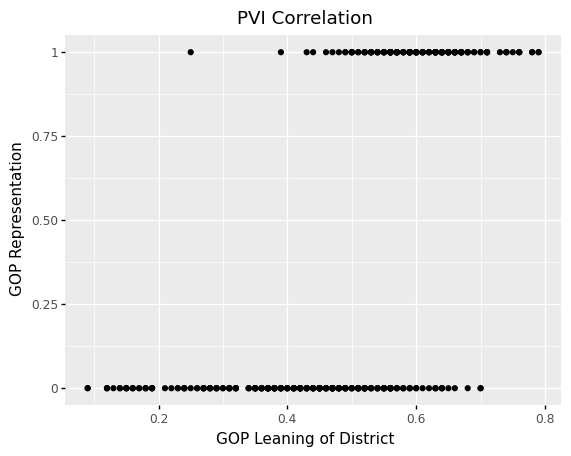

<ggplot: (8761837485150)>

In [29]:
# Create a super simple scatterplot to examine the relationship between PVI and congressional district
(p9.ggplot(data=pure_111, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y='GOP Representation',color="",title="PVI Correlation"))

In [30]:
#group by metric and average GOP seats
bm_111 = pure_111.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_111 = bm_111.reset_index()

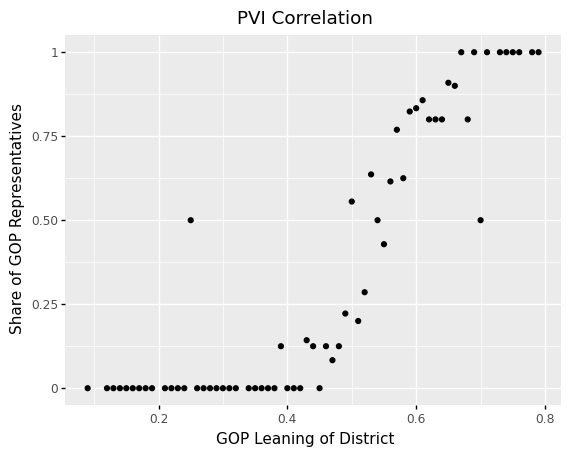

<ggplot: (8761842489507)>

In [31]:
#Plot averages
(p9.ggplot(data=bm_111, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

In [32]:
#now lets limit the data to only the R+10 to D+10 range, calling it Limited Domain
ld_111 = bm_111[bm_111["metric"] <= .55]
ld_111 = ld_111[ld_111["metric"] >= .45]

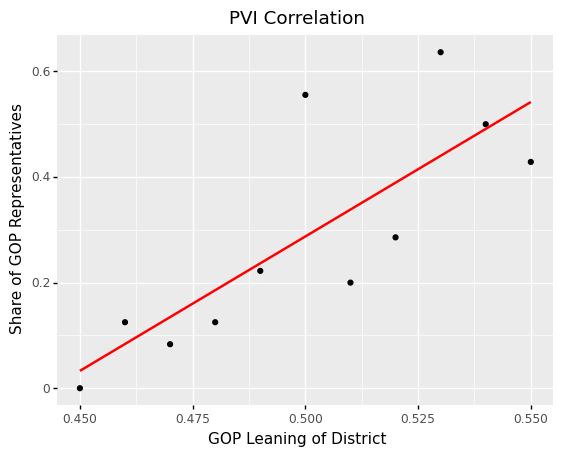

<ggplot: (8761842889421)>

In [33]:
#Plot averages
(p9.ggplot(data=ld_111, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + geom_smooth(method = "lm", color = "red", se = False)
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))